## Machine Learning: Hello World (Regressor version)!

#### The major task here is to predict median house values in Californian districts, given features from these districts

#### Dataset and coding inspiration used here can be found at: G√©ron, A. (2017). Hands-on machine learning with scikit-learn and tensorflow: Concepts. Tools, and Techniques to build intelligent systems.

# Setup

In [1]:
# Commonly used libraries
import numpy as np
import pandas as pd
import os

# From scikitlearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

# to keep stability
np.random.seed(42)

# To plot 
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Ignore useless warnings 
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Loading  and Overview of the Data 

In [2]:
housing = pd.read_csv('dataset/housing.csv')

In [3]:
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
#Check null values
housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [6]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [7]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

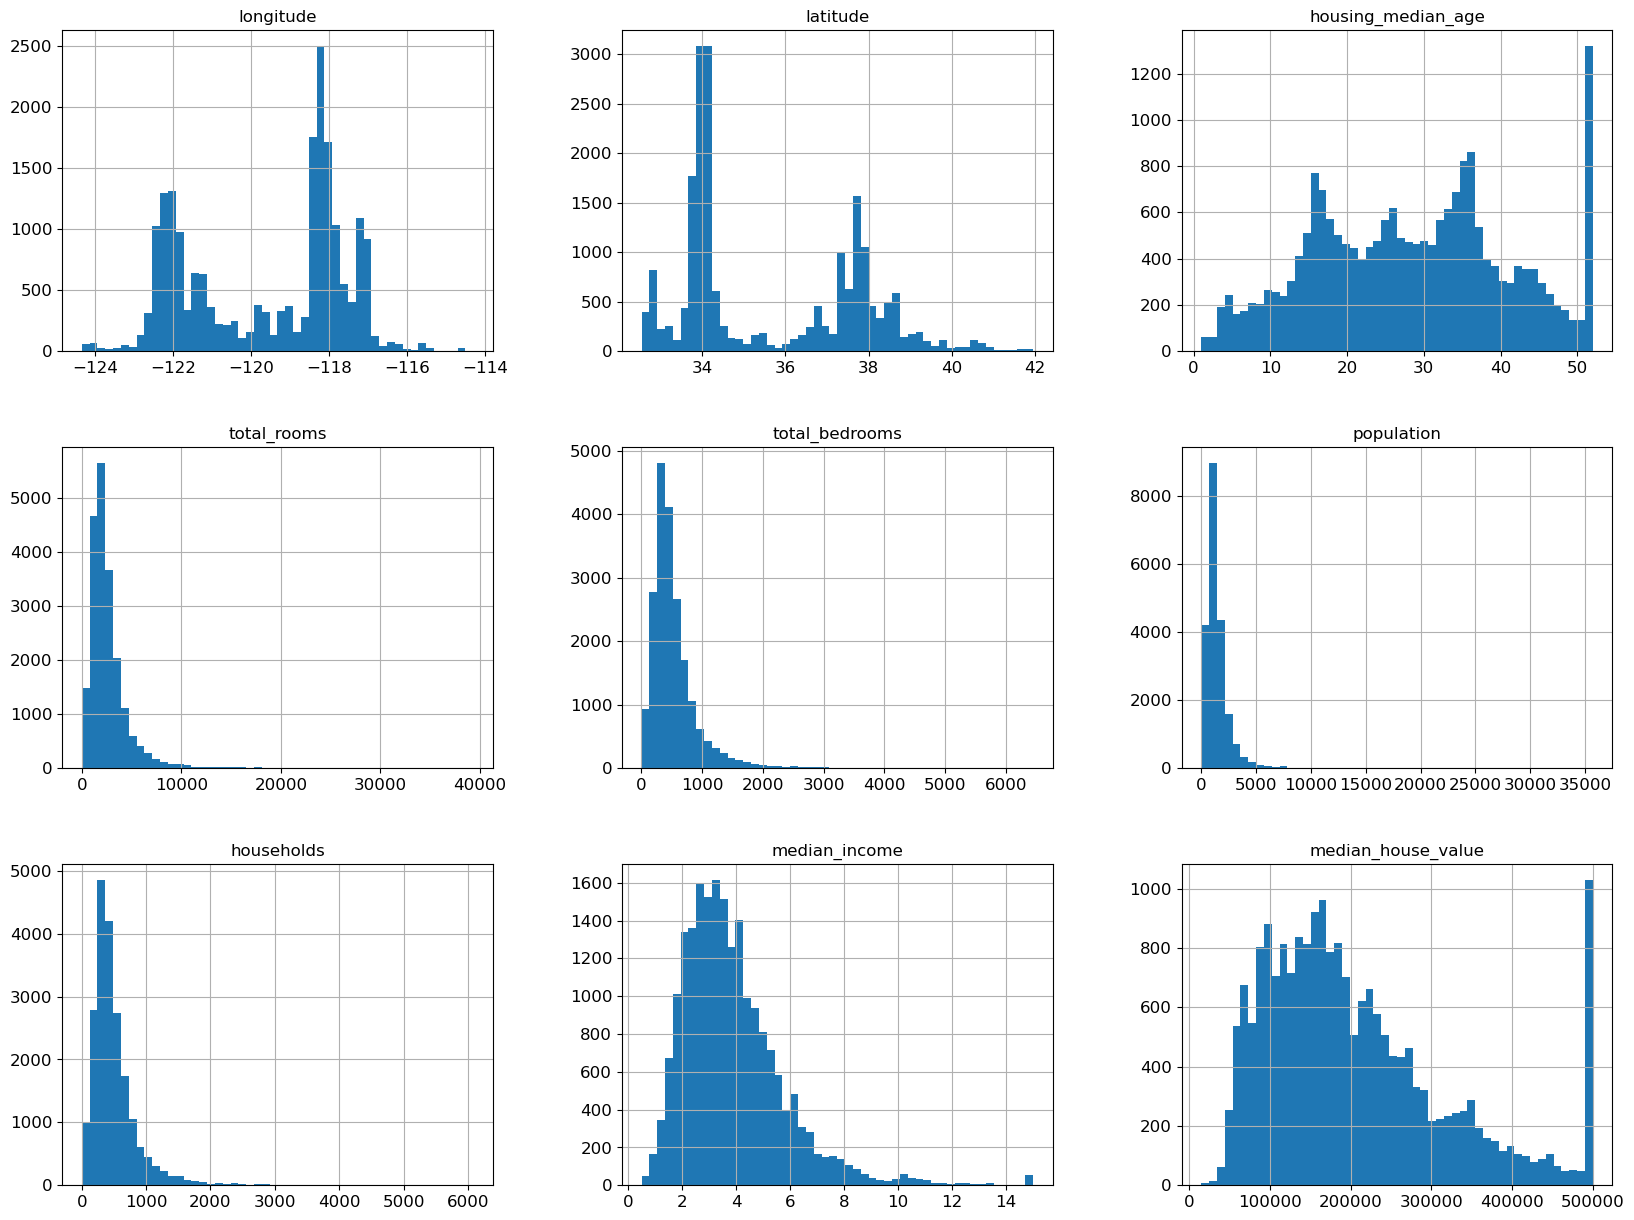

In [8]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

#### Now, we suppose experts in real estate have said that median income is very important in predicting house price, so we need to create categories for the continous variable we have 

#### We can check if it is worthy to split train and test based on this variable then...

<Axes: >

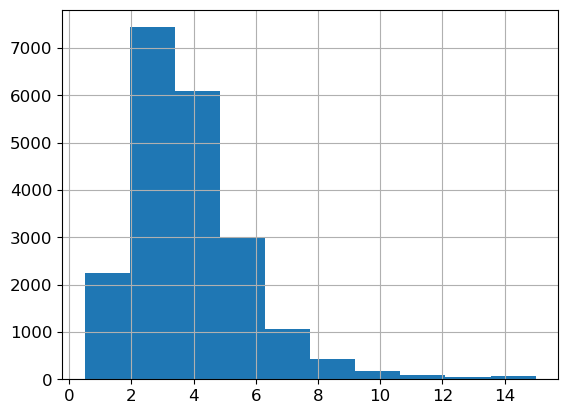

In [9]:
housing["median_income"].hist()

#### The following code creates an income category attribute by dividing the median income by 1.5 (to limit the number of income categories), and rounding up using ceil (to have discrete categories), and then merging all the categories greater than 5 into category 5:

In [11]:
#Do feature engineering to create "income_cat" feature

housing["income_cat"] = pd.cut(housing["median_income"],
bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
labels=[1, 2, 3, 4, 5])

In [12]:
#Additional, rmv median_income & convert income_cat format
housing["income_cat"] = housing["income_cat"].astype('float64')


In [13]:
housing["income_cat"].value_counts()

income_cat
3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: count, dtype: int64

<Axes: >

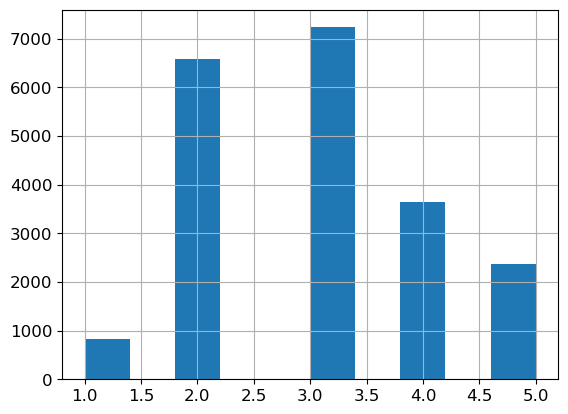

In [14]:
housing["income_cat"].hist()

In [15]:
housing["income_cat"].value_counts() / len(housing)

income_cat
3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: count, dtype: float64

# Discover and visualize the data to gain insights

In [18]:
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  \
0       322.0       126.0         8.3252            452600.0        NEAR BAY   
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY   
2       496.0       177.0         7.2574            352100.0        NEAR BAY   
3       558.0       219.0         5.6431            341300.0        NEAR BAY   
4       565.0       259.0         3.8462            342200.0        NEAR BAY   

   income_cat  
0         5.0  
1         5.0  
2         5.0  
3         4.0  
4         3.0

<Axes: xlabel='longitude', ylabel='latitude'>

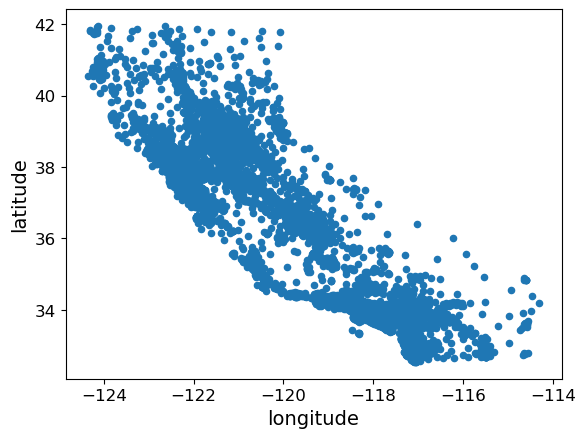

In [19]:
housing.plot(kind="scatter", x="longitude", y="latitude")

<Axes: xlabel='longitude', ylabel='latitude'>

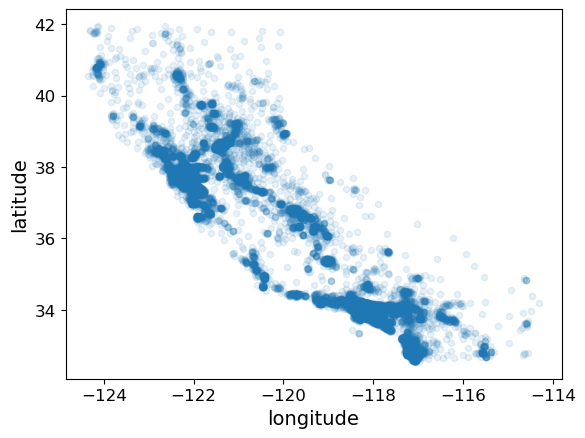

In [20]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

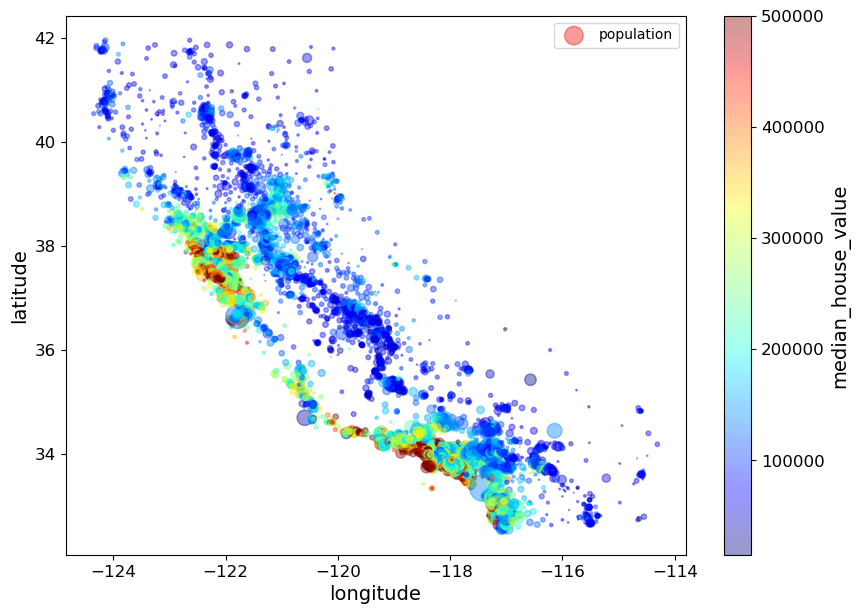

In [21]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

In [22]:
corr_matrix = housing.corr(numeric_only = True)
corr_matrix

longitude  latitude  housing_median_age  total_rooms  \
longitude            1.000000 -0.924664           -0.108197     0.044568   
latitude            -0.924664  1.000000            0.011173    -0.036100   
housing_median_age  -0.108197  0.011173            1.000000    -0.361262   
total_rooms          0.044568 -0.036100           -0.361262     1.000000   
total_bedrooms       0.069608 -0.066983           -0.320451     0.930380   
population           0.099773 -0.108785           -0.296244     0.857126   
households           0.055310 -0.071035           -0.302916     0.918484   
median_income       -0.015176 -0.079809           -0.119034     0.198050   
median_house_value  -0.045967 -0.144160            0.105623     0.134153   
income_cat          -0.010690 -0.085528           -0.146920     0.220528   

                    total_bedrooms  population  households  median_income  \
longitude                 0.069608    0.099773    0.055310      -0.015176   
latitude                 -0.066983   -0.108785   -0.071035      -0.079809   
housing_median_age       -0.320451   -0.296244   -0.302916      -0.119034   
total_rooms               0.930380    0.857126    0.918484       0.198050   
total_bedrooms            1.000000    0.877747    0.979728      -0.007723   
population                0.877747    1.000000    0.907222       0.004834   
households                0.979728    0.907222    1.000000       0.013033   
median_income            -0.007723    0.004834    0.013033       1.000000   
median_house_value        0.049686   -0.024650    0.065843       0.688075   
income_cat                0.015662    0.025809    0.038490       0.902750   

                    median_house_value  income_cat  
longitude                    -0.045967   -0.010690  
latitude                     -0.144160   -0.085528  
housing_median_age            0.105623   -0.146920  
total_rooms                   0.134153    0.220528  
total_bedrooms                0.049686    0.015662  
population                   -0.024650    0.025809  
households                    0.065843    0.038490  
median_income                 0.688075    0.902750  
median_house_value            1.000000    0.643892  
income_cat                    0.643892    1.000000

In [23]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
income_cat            0.643892
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

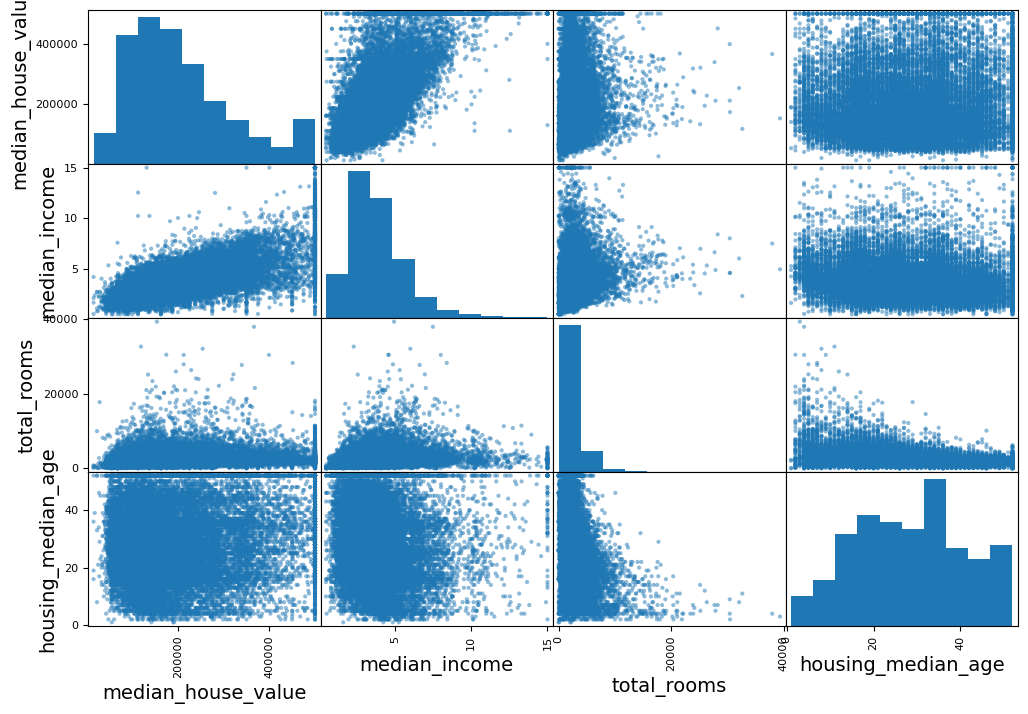

In [24]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

<Axes: xlabel='median_income', ylabel='median_house_value'>

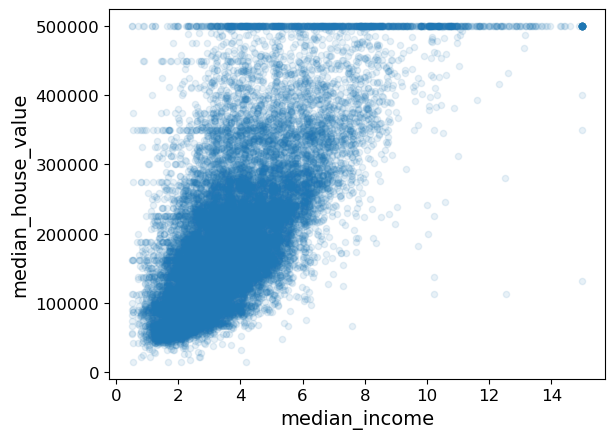

In [25]:
#Median Income vs House Value
housing.plot(kind="scatter", x="median_income", y="median_house_value",
alpha=0.1)

In [26]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value    income_cat  
count        20640.000000  20640.000000  
mean        206855.816909      3.006686  
std         115395.615874      1.054618  
min          14999.000000      1.000000  
25%         119600.000000      2.000000  
50%         179700.000000      3.000000  
75%         264725.000000      4.000000  
max         500001.000000      5.000000

# Prepare the data for Machine Learning algorithms

In [27]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
290    -122.16     37.77                47.0       1256.0             NaN   
341    -122.17     37.75                38.0        992.0             NaN   
538    -122.28     37.78                29.0       5154.0             NaN   
563    -122.24     37.75                45.0        891.0             NaN   
696    -122.10     37.69                41.0        746.0             NaN   

     population  households  median_income  median_house_value  \
290       570.0       218.0         4.3750            161900.0   
341       732.0       259.0         1.6196             85100.0   
538      3741.0      1273.0         2.5762            173400.0   
563       384.0       146.0         4.9489            247100.0   
696       387.0       161.0         3.9063            178400.0   

    ocean_proximity  income_cat  
290        NEAR BAY         3.0  
341        NEAR BAY         2.0  
538        NEAR BAY         2.0  
563        NEAR BAY         4.0  
696        NEAR BAY         3.0

In [36]:
# option 1 - to drop missing values
#sample_incomplete_rows.dropna(subset=["total_bedrooms"])    

In [37]:
# option 2 - to drop missing values
#sample_incomplete_rows.drop("total_bedrooms", axis=1)       # option 2

In [38]:
# option 3 - fill nan with median in specific column
#median = housing["total_bedrooms"].median()
#sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) 
#sample_incomplete_rows

In [28]:
# option 4 - use imputer in the whole data, but we need to revome categorical feature (missing) before, 
# because it will only work on numerical data

imputer = SimpleImputer(strategy="median")

Remove the text attribute because median can only be calculated on numerical attributes:

In [29]:
housing_num = housing.drop('ocean_proximity', axis=1)
# alternatively: housing_num = housing.select_dtypes(include=[np.number])

In [30]:
housing_num

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88                41.0        880.0           129.0   
1        -122.22     37.86                21.0       7099.0          1106.0   
2        -122.24     37.85                52.0       1467.0           190.0   
3        -122.25     37.85                52.0       1274.0           235.0   
4        -122.25     37.85                52.0       1627.0           280.0   
...          ...       ...                 ...          ...             ...   
20635    -121.09     39.48                25.0       1665.0           374.0   
20636    -121.21     39.49                18.0        697.0           150.0   
20637    -121.22     39.43                17.0       2254.0           485.0   
20638    -121.32     39.43                18.0       1860.0           409.0   
20639    -121.24     39.37                16.0       2785.0           616.0   

       population  households  median_income  median_house_value  income_cat  
0           322.0       126.0         8.3252            452600.0         5.0  
1          2401.0      1138.0         8.3014            358500.0         5.0  
2           496.0       177.0         7.2574            352100.0         5.0  
3           558.0       219.0         5.6431            341300.0         4.0  
4           565.0       259.0         3.8462            342200.0         3.0  
...           ...         ...            ...                 ...         ...  
20635       845.0       330.0         1.5603             78100.0         2.0  
20636       356.0       114.0         2.5568             77100.0         2.0  
20637      1007.0       433.0         1.7000             92300.0         2.0  
20638       741.0       349.0         1.8672             84700.0         2.0  
20639      1387.0       530.0         2.3886             89400.0         2.0  

[20640 rows x 10 columns]

In [31]:
imputer.fit(housing_num)

# The imputer has simply computed the median of each attribute and stored the result in its statistics_ 
# instance variable. Only the total_bedrooms attribute had missing values, but we cannot be sure that 
# there won‚Äôt be any missing values in new data after the system goes live, so it is safer to 
# apply the imputer to all the numerical attributes

SimpleImputer(strategy='median')

In [32]:
imputer.statistics_

array([-1.1849e+02,  3.4260e+01,  2.9000e+01,  2.1270e+03,  4.3500e+02,
        1.1660e+03,  4.0900e+02,  3.5348e+00,  1.7970e+05,  3.0000e+00])

In [33]:
housing_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   income_cat          20640 non-null  float64
dtypes: float64(10)
memory usage: 1.6 MB


Check that this is the same as manually computing the median of each attribute:

In [34]:
housing_num.median().values


array([-1.1849e+02,  3.4260e+01,  2.9000e+01,  2.1270e+03,  4.3500e+02,
        1.1660e+03,  4.0900e+02,  3.5348e+00,  1.7970e+05,  3.0000e+00])

In [35]:
housing_num

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88                41.0        880.0           129.0   
1        -122.22     37.86                21.0       7099.0          1106.0   
2        -122.24     37.85                52.0       1467.0           190.0   
3        -122.25     37.85                52.0       1274.0           235.0   
4        -122.25     37.85                52.0       1627.0           280.0   
...          ...       ...                 ...          ...             ...   
20635    -121.09     39.48                25.0       1665.0           374.0   
20636    -121.21     39.49                18.0        697.0           150.0   
20637    -121.22     39.43                17.0       2254.0           485.0   
20638    -121.32     39.43                18.0       1860.0           409.0   
20639    -121.24     39.37                16.0       2785.0           616.0   

       population  households  median_income  median_house_value  income_cat  
0           322.0       126.0         8.3252            452600.0         5.0  
1          2401.0      1138.0         8.3014            358500.0         5.0  
2           496.0       177.0         7.2574            352100.0         5.0  
3           558.0       219.0         5.6431            341300.0         4.0  
4           565.0       259.0         3.8462            342200.0         3.0  
...           ...         ...            ...                 ...         ...  
20635       845.0       330.0         1.5603             78100.0         2.0  
20636       356.0       114.0         2.5568             77100.0         2.0  
20637      1007.0       433.0         1.7000             92300.0         2.0  
20638       741.0       349.0         1.8672             84700.0         2.0  
20639      1387.0       530.0         2.3886             89400.0         2.0  

[20640 rows x 10 columns]

In [36]:
housing_num.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
income_cat              0
dtype: int64

Transform the training set:

In [37]:
# we use the ‚Äútrained‚Äù imputer to transform the training set by replacing missing values by the learned medians:
X = imputer.transform(housing_num)

# The result is a plain Numpy array containing the transformed features. If you want to put it back into 
# a Pandas DataFrame, it‚Äôs simple:

In [38]:
X

array([[-1.2223e+02,  3.7880e+01,  4.1000e+01, ...,  8.3252e+00,
         4.5260e+05,  5.0000e+00],
       [-1.2222e+02,  3.7860e+01,  2.1000e+01, ...,  8.3014e+00,
         3.5850e+05,  5.0000e+00],
       [-1.2224e+02,  3.7850e+01,  5.2000e+01, ...,  7.2574e+00,
         3.5210e+05,  5.0000e+00],
       ...,
       [-1.2122e+02,  3.9430e+01,  1.7000e+01, ...,  1.7000e+00,
         9.2300e+04,  2.0000e+00],
       [-1.2132e+02,  3.9430e+01,  1.8000e+01, ...,  1.8672e+00,
         8.4700e+04,  2.0000e+00],
       [-1.2124e+02,  3.9370e+01,  1.6000e+01, ...,  2.3886e+00,
         8.9400e+04,  2.0000e+00]])

In [39]:
housing_num = pd.DataFrame(X, columns=housing_num.columns, index = list(housing.index.values))
housing_num.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   income_cat          20640 non-null  float64
dtypes: float64(10)
memory usage: 1.7 MB


In [40]:
housing_num.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value  income_cat  
0       322.0       126.0         8.3252            452600.0         5.0  
1      2401.0      1138.0         8.3014            358500.0         5.0  
2       496.0       177.0         7.2574            352100.0         5.0  
3       558.0       219.0         5.6431            341300.0         4.0  
4       565.0       259.0         3.8462            342200.0         3.0

In [41]:
housing['total_bedrooms'] = housing_num['total_bedrooms']

In [42]:
housing.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
income_cat            0
dtype: int64

In [43]:
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  \
0       322.0       126.0         8.3252            452600.0        NEAR BAY   
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY   
2       496.0       177.0         7.2574            352100.0        NEAR BAY   
3       558.0       219.0         5.6431            341300.0        NEAR BAY   
4       565.0       259.0         3.8462            342200.0        NEAR BAY   

   income_cat  
0         5.0  
1         5.0  
2         5.0  
3         4.0  
4         3.0

## Additional DPT-1: Feature Engineering

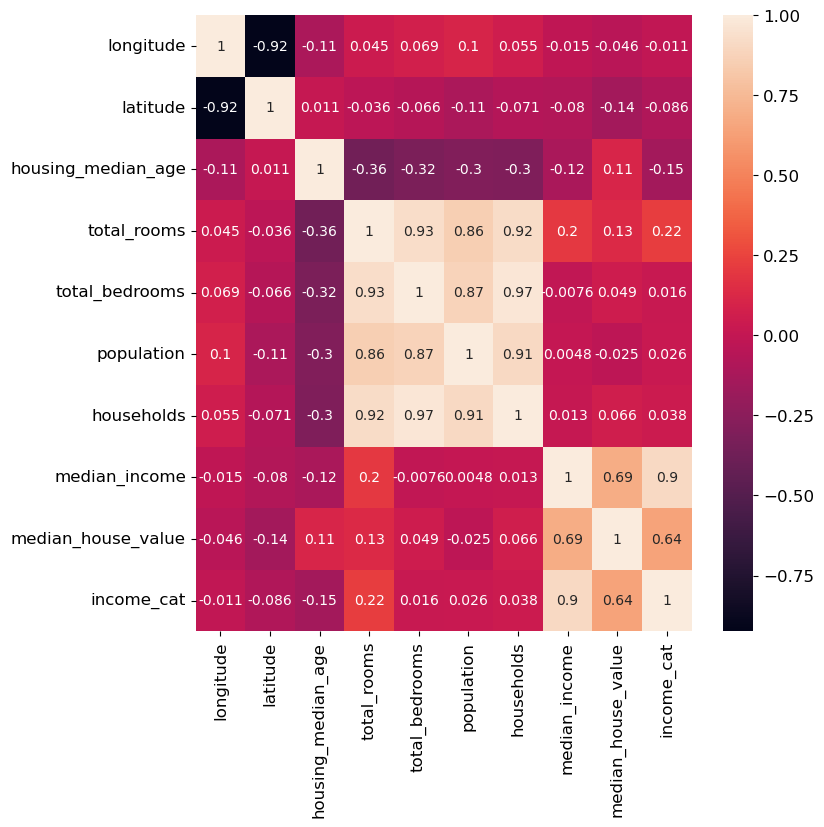

In [44]:
#Correlation check
import seaborn as sns 

corr = housing.corr(numeric_only=True)
plt.figure(figsize = (8,8))

sns.heatmap(corr, annot=True)
plt.show()

In [45]:
# We can see that several features (total_rooms,total_bedrooms,population,households) have very high correlation to one another, 
# so it's interesting to find out if a removal of a few of them would have any affect on the model performance

#  a new feature that is a ratio of the total rooms to households
housing['rooms_per_household'] = housing['total_rooms']/housing['households']

# a new feature that is a ratio of the total bedrooms to the total rooms 
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']

# a new feature that is a ratio of the population to the households 
housing['population_per_household']= housing['population']/housing['households']

housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 20640 non-null  float64
 1   latitude                  20640 non-null  float64
 2   housing_median_age        20640 non-null  float64
 3   total_rooms               20640 non-null  float64
 4   total_bedrooms            20640 non-null  float64
 5   population                20640 non-null  float64
 6   households                20640 non-null  float64
 7   median_income             20640 non-null  float64
 8   median_house_value        20640 non-null  float64
 9   ocean_proximity           20640 non-null  object 
 10  income_cat                20640 non-null  float64
 11  rooms_per_household       20640 non-null  float64
 12  bedrooms_per_room         20640 non-null  float64
 13  population_per_household  20640 non-null  float64
dtypes: flo

## Additional DPT-2: Feature Selection

In [46]:
# remove total_rooms, households, total bedrooms, popluation, median income
housing = housing.drop('total_rooms', axis=1)
housing = housing.drop('households', axis=1)
housing = housing.drop('total_bedrooms', axis=1)
housing = housing.drop('population', axis=1)
housing = housing.drop('median_income', axis=1)

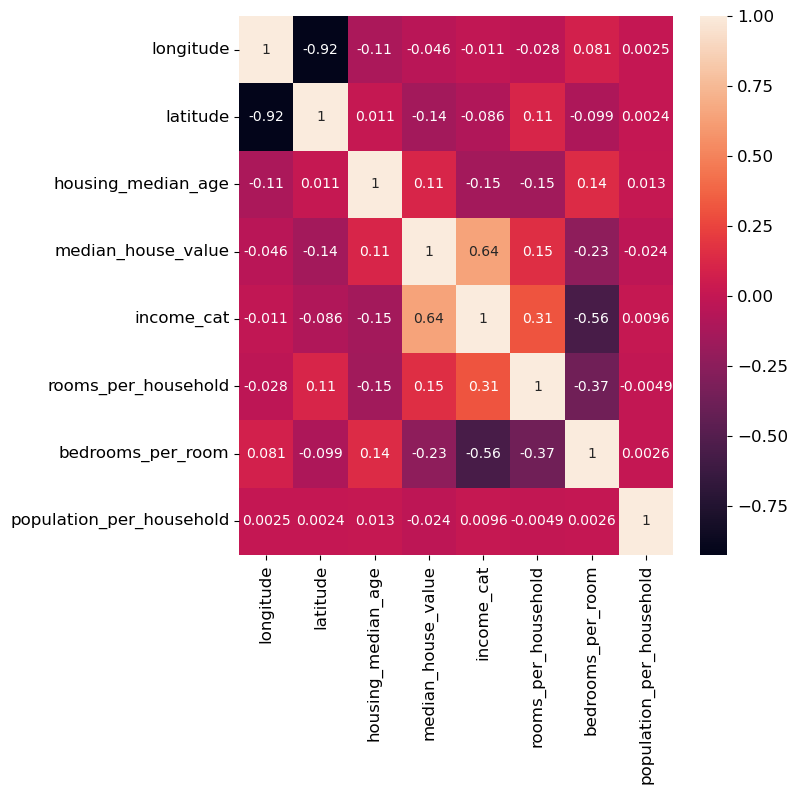

In [47]:
corr = housing.corr(numeric_only=True) 

#make the heatmap larger in size
plt.figure(figsize = (7,7))

sns.heatmap(corr, annot=True)
plt.show()

## DPT-3 Improvement of 1 hot encoding categorical value

Now let's preprocess the categorical input feature, `ocean_proximity`:

In [48]:
#housing_cat = housing[['ocean_proximity']]
#housing_cat.head(10)

In [49]:
# One option is to use OrdinalEncoder

#ordinal_encoder = OrdinalEncoder()
#housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
#housing_cat_encoded[:10]

In [50]:
#ordinal_encoder.categories_
housing.ocean_proximity.unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [51]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [52]:
# Another option is to use OneHotEncoder
#Error-3

#from sklearn.preprocessing import OneHotEncoder
#cat_encoder = OneHotEncoder()
#housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
#housing_cat_1hot

In [53]:
# Use Panda's get_dummies() function
print(pd.get_dummies(housing['ocean_proximity']))

       <1H OCEAN  INLAND  ISLAND  NEAR BAY  NEAR OCEAN
0          False   False   False      True       False
1          False   False   False      True       False
2          False   False   False      True       False
3          False   False   False      True       False
4          False   False   False      True       False
...          ...     ...     ...       ...         ...
20635      False    True   False     False       False
20636      False    True   False     False       False
20637      False    True   False     False       False
20638      False    True   False     False       False
20639      False    True   False     False       False

[20640 rows x 5 columns]


In [54]:
# Replace the OCEAN_PROXIMITY column using get_dummies()
housing_encoded = pd.get_dummies(data=housing, columns=['ocean_proximity'])

# print the first few observations; notice the old OCEAN_PROXIMITY column is gone
housing_encoded.head()

longitude  latitude  housing_median_age  median_house_value  income_cat  \
0    -122.23     37.88                41.0            452600.0         5.0   
1    -122.22     37.86                21.0            358500.0         5.0   
2    -122.24     37.85                52.0            352100.0         5.0   
3    -122.25     37.85                52.0            341300.0         4.0   
4    -122.25     37.85                52.0            342200.0         3.0   

   rooms_per_household  bedrooms_per_room  population_per_household  \
0             6.984127           0.146591                  2.555556   
1             6.238137           0.155797                  2.109842   
2             8.288136           0.129516                  2.802260   
3             5.817352           0.184458                  2.547945   
4             6.281853           0.172096                  2.181467   

   ocean_proximity_<1H OCEAN  ocean_proximity_INLAND  ocean_proximity_ISLAND  \
0                      False                   False                   False   
1                      False                   False                   False   
2                      False                   False                   False   
3                      False                   False                   False   
4                      False                   False                   False   

   ocean_proximity_NEAR BAY  ocean_proximity_NEAR OCEAN  
0                      True                       False  
1                      True                       False  
2                      True                       False  
3                      True                       False  
4                      True                       False

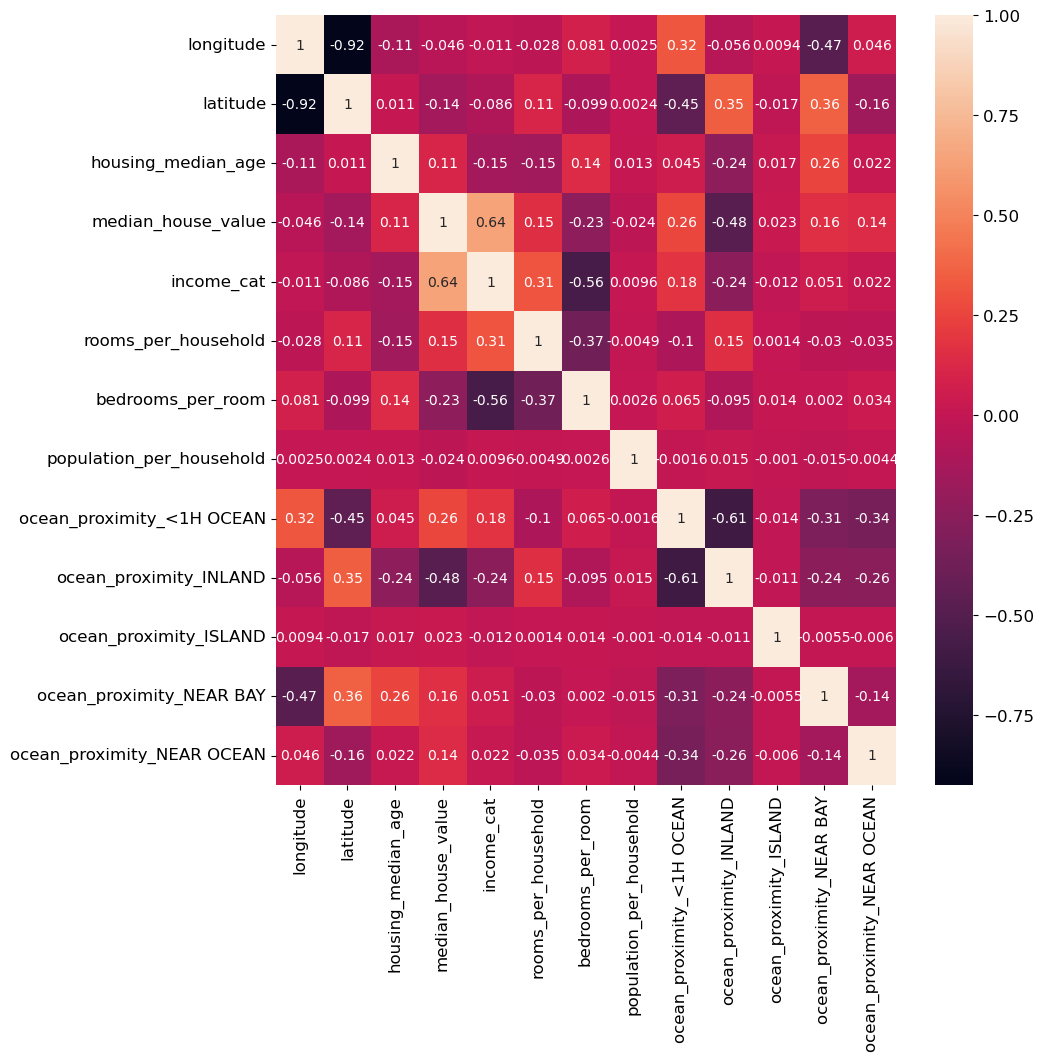

In [55]:
corr = housing_encoded.corr() 

#make the heatmap larger in size
plt.figure(figsize = (10,10))

sns.heatmap(corr, annot=True)
plt.show()

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'median_house_value'}>,
        <Axes: title={'center': 'income_cat'}>,
        <Axes: title={'center': 'rooms_per_household'}>],
       [<Axes: title={'center': 'bedrooms_per_room'}>,
        <Axes: title={'center': 'population_per_household'}>, <Axes: >]],
      dtype=object)

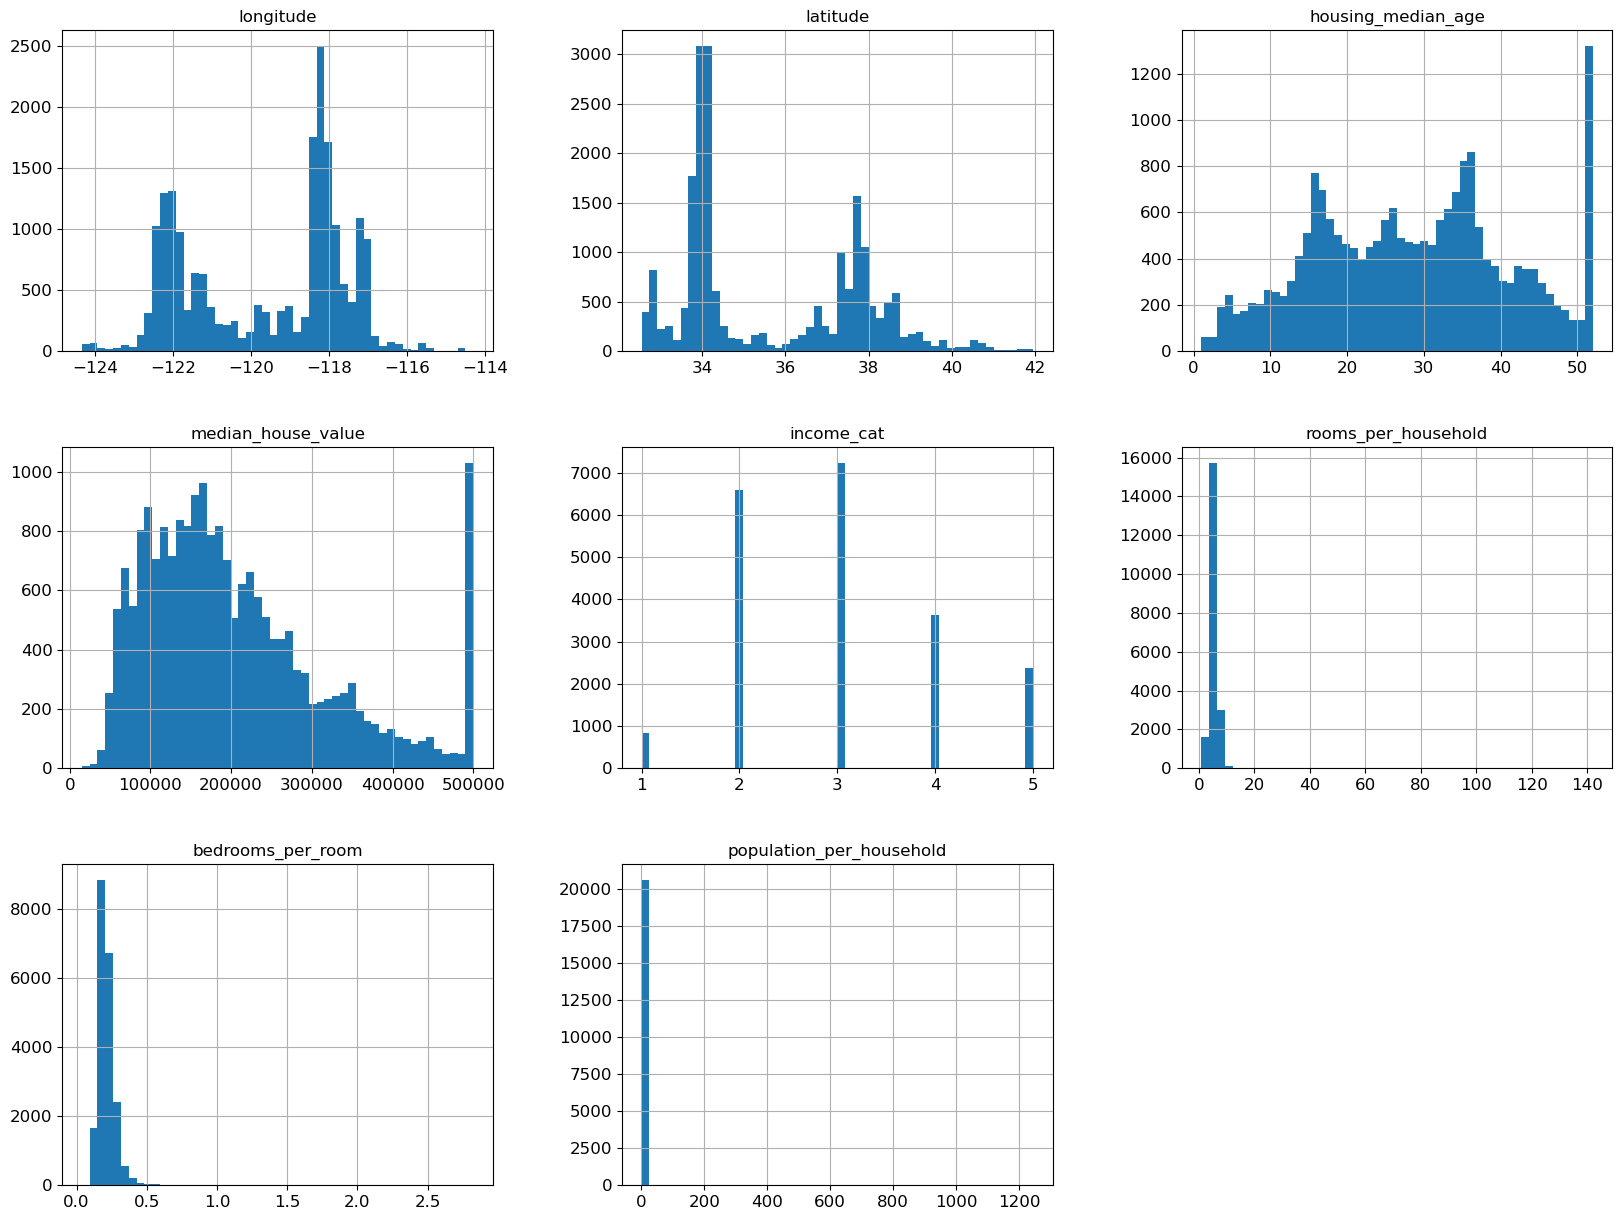

In [56]:
housing_encoded.hist(bins=50, figsize=(20,15))

In [57]:
housing_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   longitude                   20640 non-null  float64
 1   latitude                    20640 non-null  float64
 2   housing_median_age          20640 non-null  float64
 3   median_house_value          20640 non-null  float64
 4   income_cat                  20640 non-null  float64
 5   rooms_per_household         20640 non-null  float64
 6   bedrooms_per_room           20640 non-null  float64
 7   population_per_household    20640 non-null  float64
 8   ocean_proximity_<1H OCEAN   20640 non-null  bool   
 9   ocean_proximity_INLAND      20640 non-null  bool   
 10  ocean_proximity_ISLAND      20640 non-null  bool   
 11  ocean_proximity_NEAR BAY    20640 non-null  bool   
 12  ocean_proximity_NEAR OCEAN  20640 non-null  bool   
dtypes: bool(5), float64(8)
memory u

# Select and train a model 

In [58]:
#Split The Data
import sklearn
from sklearn.model_selection import train_test_split

# remove spaces from column names and convert all to lowercase and remove special characters as it could cause issues in the future
housing_encoded.columns = [c.lower().replace(' ', '_').replace('<', '_') for c in housing_encoded.columns]

# Split target variable and feature variables
X = housing_encoded[['longitude','latitude','housing_median_age', 'income_cat','rooms_per_household','bedrooms_per_room','population_per_household','ocean_proximity__1h_ocean',
                        'ocean_proximity_inland','ocean_proximity_island','ocean_proximity_near_bay','ocean_proximity_near_ocean']]
y = housing_encoded['median_house_value']

print(X)
print(y)

       longitude  latitude  housing_median_age  income_cat  \
0        -122.23     37.88                41.0         5.0   
1        -122.22     37.86                21.0         5.0   
2        -122.24     37.85                52.0         5.0   
3        -122.25     37.85                52.0         4.0   
4        -122.25     37.85                52.0         3.0   
...          ...       ...                 ...         ...   
20635    -121.09     39.48                25.0         2.0   
20636    -121.21     39.49                18.0         2.0   
20637    -121.22     39.43                17.0         2.0   
20638    -121.32     39.43                18.0         2.0   
20639    -121.24     39.37                16.0         2.0   

       rooms_per_household  bedrooms_per_room  population_per_household  \
0                 6.984127           0.146591                  2.555556   
1                 6.238137           0.155797                  2.109842   
2                 8.288136    

In [59]:
# Splitting the data into training and testing sets in numpy arrays
# We train the model with 70% of the samples and test with the remaining 30%
# X -> array with the inputs; y -> array of the outputs
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True, test_size=0.2)

# Confirm how the data was split
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(16512, 12)
(4128, 12)
(16512,)
(4128,)


In [62]:
#Model-1 LinearRegression Training
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [63]:
#run the predictions on the training and testing data
y_pred_test = lin_reg.predict(X_test)

In [64]:
#compare the actual values (ie, target) with the values predicted by the model
pred_test_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test})

pred_test_df

Actual      Predicted
20046   47700.0   94094.598917
3024    45800.0   99749.452281
15663  500001.0  233473.651764
20484  218600.0  269304.491814
9814   278000.0  264577.797837
...         ...            ...
15362  263300.0  256781.241390
16623  266800.0  199291.259104
18086  500001.0  364067.198103
2144    72300.0   83425.637491
3665   151500.0  214108.369583

[4128 rows x 2 columns]

In [65]:
# Determine accuracy uisng ùëÖ^2 & RMSE
# ùëÖ^2 : R squared is another way to evaluate the performance of a regression model.
# 1, means that the model is perfect and 0 means the the model will perform poorly.
from sklearn.metrics import r2_score, mean_squared_error
r2_reg_model_test = round(lin_reg.score(X_test, y_test),2)

print("R^2 Test: {}".format(r2_reg_model_test))
print('RMSE on test data: ',  mean_squared_error(y_test, y_pred_test)**(0.5))

R^2 Test: 0.51
RMSE on test data:  79782.05330112236


In [66]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(y_test, y_pred_test)
lin_mae

58390.793076320486

In [67]:
#Model 2: Decision Tree
from sklearn.tree import DecisionTreeRegressor

#tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor()

In [68]:
#run the predictions on the training and testing data
y_pred_test2 = tree_reg.predict(X_test)

In [69]:
#housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(y_test, y_pred_test2)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

71439.670887744

In [70]:
#Model 3: Gradient Boosting

from sklearn.ensemble import GradientBoostingRegressor

gb_r = GradientBoostingRegressor()
gb_r.fit(X_train, y_train)

GradientBoostingRegressor()

In [71]:
#run the predictions on the training and testing data
y_pred_test3 = gb_r.predict(X_test)

In [72]:
#housing_predictions using Gradient Boosting
gbr_mse = mean_squared_error(y_test, y_pred_test3)
gbr_rmse = np.sqrt(gbr_mse)
gbr_rmse

55826.02054227429

In [73]:
#Model 4: Support Vector Regressor
from sklearn.svm import SVR

svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_model.fit(X_train, y_train)

SVR()

In [74]:
#run the predictions on the training and testing data
y_pred_test4 = svr_model.predict(X_test)

In [75]:
#housing_predictions using Support Vector Regressor
svr_mse = mean_squared_error(y_test, y_pred_test4)
svr_rmse = np.sqrt(svr_mse)
svr_rmse

117310.03985719092

In [76]:
#Model 5: XG Boost Regression
import xgboost as xgb
xgb_regressor = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [77]:
#run the predictions on the training and testing data
y_pred_test5 = xgb_regressor.predict(X_test)

In [78]:
#housing_predictions using XG Boost Regressor
xgb_mse = mean_squared_error(y_test, y_pred_test5)
xgb_rmse = np.sqrt(svr_mse)
xgb_rmse

117310.03985719092

So after compare 5 model, the best model to predict the housing price is Gradient Boost Regressor. Now we try to fine tune the model to get a better result from the best model.

# Fine-tune your model

In [79]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(gb_r, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
gbr_rmse_scores = np.sqrt(-scores)

In [80]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(gbr_rmse_scores)

Scores: [53676.91011583 56144.68658775 54059.01695108 53332.65746373
 57176.20843481 52354.11250002 51652.7911359  55566.329837
 55639.23879628 56486.9009371 ]
Mean: 54608.88527595075
Standard deviation: 1762.8751600040544


In [81]:
lin_scores = cross_val_score(lin_reg, X_train, y_train,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [72473.72172492 79377.28804296 73597.42400801 73692.98430102
 77271.82005336 75295.25526689 73851.44718709 75045.44699356
 75545.65112405 78114.72888646]
Mean: 75426.57675883229
Standard deviation: 2096.8408828325605


In [82]:
#HYPERPARAMETER TUNING-1 GRIDSEARCH
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3√ó4) combinations of hyperparameters
    {'max_features': [2, 4, 6, 8]},
    # then try 6 (2√ó3) 
    {'max_features': [2, 3, 4]},
  ]

#tree_reg = DecisionTreeRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(gb_r, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8]},
                         {'max_features': [2, 3, 4]}],
             return_train_score=True, scoring='neg_mean_squared_error')

The best hyperparameter combination found:

In [83]:
grid_search.best_params_

{'max_features': 8}

In [84]:
grid_search.best_estimator_

GradientBoostingRegressor(max_features=8)

Let's look at the score of each hyperparameter combination tested during the grid search:

In [85]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

57728.02340633685 {'max_features': 2}
55698.08553158692 {'max_features': 4}
55207.931817404045 {'max_features': 6}
55180.78805481175 {'max_features': 8}
58016.36003000457 {'max_features': 2}
56624.037518234494 {'max_features': 3}
55940.04727556901 {'max_features': 4}


In [86]:
pd.DataFrame(grid_search.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.401732      0.025405         0.005716        0.000775   
1       0.638417      0.014644         0.005614        0.000451   
2       0.914682      0.029847         0.005186        0.000520   
3       1.190766      0.028093         0.005104        0.000358   
4       0.440008      0.039132         0.007274        0.002359   
5       0.522151      0.010428         0.005457        0.000547   
6       0.681444      0.012089         0.005682        0.000714   

  param_max_features               params  split0_test_score  \
0                  2  {'max_features': 2}      -3.436726e+09   
1                  4  {'max_features': 4}      -3.164193e+09   
2                  6  {'max_features': 6}      -3.086553e+09   
3                  8  {'max_features': 8}      -3.083722e+09   
4                  2  {'max_features': 2}      -3.328091e+09   
5                  3  {'max_features': 3}      -3.268269e+09   
6                  4  {'max_features': 4}      -3.154905e+09   

   split1_test_score  split2_test_score  split3_test_score  ...  \
0      -3.207371e+09      -3.251528e+09      -3.309724e+09  ...   
1      -3.013466e+09      -3.094144e+09      -3.023584e+09  ...   
2      -2.970149e+09      -3.040647e+09      -2.925926e+09  ...   
3      -2.954612e+09      -3.011409e+09      -3.006282e+09  ...   
4      -3.262023e+09      -3.398891e+09      -3.295334e+09  ...   
5      -3.133958e+09      -3.146343e+09      -3.120157e+09  ...   
6      -2.990920e+09      -3.167020e+09      -3.034058e+09  ...   

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0    -3.332525e+09    9.916079e+07                6       -3.185374e+09   
1    -3.102277e+09    7.862790e+07                3       -2.917860e+09   
2    -3.047916e+09    1.008259e+08                2       -2.807156e+09   
3    -3.044919e+09    7.425199e+07                1       -2.825946e+09   
4    -3.365898e+09    1.004181e+08                7       -3.099695e+09   
5    -3.206282e+09    9.438652e+07                5       -3.002198e+09   
6    -3.129289e+09    1.088863e+08                4       -2.907105e+09   

   split1_train_score  split2_train_score  split3_train_score  \
0       -3.172455e+09       -3.077688e+09       -3.171514e+09   
1       -2.919121e+09       -2.889029e+09       -2.915666e+09   
2       -2.842526e+09       -2.817359e+09       -2.818606e+09   
3       -2.828301e+09       -2.796596e+09       -2.867841e+09   
4       -3.212595e+09       -3.238396e+09       -3.136753e+09   
5       -2.992550e+09       -2.927758e+09       -3.018796e+09   
6       -2.926186e+09       -2.922691e+09       -2.893286e+09   

   split4_train_score  mean_train_score  std_train_score  
0       -3.072513e+09     -3.135909e+09     4.991787e+07  
1       -2.839977e+09     -2.896330e+09     3.028488e+07  
2       -2.797658e+09     -2.816661e+09     1.499829e+07  
3       -2.762364e+09     -2.816209e+09     3.518769e+07  
4       -3.161844e+09     -3.169857e+09     5.021326e+07  
5       -2.956410e+09     -2.979542e+09     3.298464e+07  
6       -2.911558e+09     -2.912165e+09     1.174539e+07  

[7 rows x 21 columns]

In [87]:
X_test.head()

longitude  latitude  housing_median_age  income_cat  \
20046    -119.01     36.06                25.0         2.0   
3024     -119.46     35.14                30.0         2.0   
15663    -122.44     37.80                52.0         3.0   
20484    -118.72     34.28                17.0         4.0   
9814     -121.93     36.62                34.0         3.0   

       rooms_per_household  bedrooms_per_room  population_per_household  \
20046             4.192201           0.289037                  3.877437   
3024              5.039384           0.147808                  2.679795   
15663             3.977155           0.113577                  1.360332   
20484             6.163636           0.142576                  3.444444   
9814              5.492991           0.185028                  2.483645   

       ocean_proximity__1h_ocean  ocean_proximity_inland  \
20046                      False                    True   
3024                       False                    True   
15663                      False                   False   
20484                       True                   False   
9814                       False                   False   

       ocean_proximity_island  ocean_proximity_near_bay  \
20046                   False                     False   
3024                    False                     False   
15663                   False                      True   
20484                   False                     False   
9814                    False                     False   

       ocean_proximity_near_ocean  
20046                       False  
3024                        False  
15663                       False  
20484                       False  
9814                         True

In [90]:
final_model = grid_search.best_estimator_

#X_test1 = X_test.drop("median_house_value", axis=1)
#y_test1 = y_test["median_house_value"].copy()

#X_test_prepared1 = full_pipeline.transform(X_test1)
final_predictions = final_model.predict(X_test)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [91]:
final_rmse

55812.64007445616

In [92]:
#HYPERPARAMETER TUNING-2 RANDOM SEARCH
from sklearn.model_selection import RandomizedSearchCV

grid = [
    # try 12 (3√ó4) combinations of hyperparameters
    {'max_features': [2, 4, 6, 8]},
    # then try 6 (2√ó3) 
    {'max_features': [2, 3, 4]},
  ]


#tree_reg2 = DecisionTreeRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
rand_search = RandomizedSearchCV(gb_r, param_distributions=grid, cv=5,n_iter=7,
                           scoring='neg_mean_squared_error', return_train_score=True)
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_iter=7,
                   param_distributions=[{'max_features': [2, 4, 6, 8]},
                                        {'max_features': [2, 3, 4]}],
                   return_train_score=True, scoring='neg_mean_squared_error')

In [93]:
rand_search.best_estimator_

GradientBoostingRegressor(max_features=6)

In [94]:
cvres2 = rand_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

57728.02340633685 {'max_features': 2}
55698.08553158692 {'max_features': 4}
55207.931817404045 {'max_features': 6}
55180.78805481175 {'max_features': 8}
58016.36003000457 {'max_features': 2}
56624.037518234494 {'max_features': 3}
55940.04727556901 {'max_features': 4}


In [95]:
final_model2 = rand_search.best_estimator_

#X_test = strat_test_set.drop("median_house_value", axis=1)
#y_test = strat_test_set["median_house_value"].copy()

#X_test_prepared = full_pipeline.transform(X_test)
final_predictions2 = final_model2.predict(X_test)

final_mse = mean_squared_error(y_test, final_predictions2)
final_rmse = np.sqrt(final_mse)
final_rmse

56416.3625095899

In [96]:
#HYPERPARAMETER TUNING-3 BAYESIAN SEARCH
from skopt import BayesSearchCV

search_space = [
    # try 12 (3√ó4) combinations of hyperparameters
    {'max_features': [2, 4, 6, 8]},
    # then try 6 (2√ó3) 
    {'max_features': [2, 3, 4]},
  ]

#tree_reg3 = DecisionTreeRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
bayes_search = BayesSearchCV(gb_r, search_space, cv=5,n_iter=7,
                           scoring='neg_mean_squared_error', return_train_score=True)
bayes_search.fit(X_train, y_train)

BayesSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_iter=7,
              return_train_score=True, scoring='neg_mean_squared_error',
              search_spaces=[{'max_features': [2, 4, 6, 8]},
                             {'max_features': [2, 3, 4]}])

In [97]:
bayes_search.best_estimator_

GradientBoostingRegressor(max_features=8)

In [98]:
cvres3 = bayes_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

57728.02340633685 {'max_features': 2}
55698.08553158692 {'max_features': 4}
55207.931817404045 {'max_features': 6}
55180.78805481175 {'max_features': 8}
58016.36003000457 {'max_features': 2}
56624.037518234494 {'max_features': 3}
55940.04727556901 {'max_features': 4}


In [99]:
final_model3 = bayes_search.best_estimator_

#X_test = strat_test_set.drop("median_house_value", axis=1)
#y_test = strat_test_set["median_house_value"].copy()

#X_test_prepared = full_pipeline.transform(X_test)
final_predictions3 = final_model3.predict(X_test)

final_mse = mean_squared_error(y_test, final_predictions3)
final_rmse = np.sqrt(final_mse)
final_rmse

56577.57889914351

In [100]:
housing_encoded

longitude  latitude  housing_median_age  median_house_value  \
0        -122.23     37.88                41.0            452600.0   
1        -122.22     37.86                21.0            358500.0   
2        -122.24     37.85                52.0            352100.0   
3        -122.25     37.85                52.0            341300.0   
4        -122.25     37.85                52.0            342200.0   
...          ...       ...                 ...                 ...   
20635    -121.09     39.48                25.0             78100.0   
20636    -121.21     39.49                18.0             77100.0   
20637    -121.22     39.43                17.0             92300.0   
20638    -121.32     39.43                18.0             84700.0   
20639    -121.24     39.37                16.0             89400.0   

       income_cat  rooms_per_household  bedrooms_per_room  \
0             5.0             6.984127           0.146591   
1             5.0             6.238137           0.155797   
2             5.0             8.288136           0.129516   
3             4.0             5.817352           0.184458   
4             3.0             6.281853           0.172096   
...           ...                  ...                ...   
20635         2.0             5.045455           0.224625   
20636         2.0             6.114035           0.215208   
20637         2.0             5.205543           0.215173   
20638         2.0             5.329513           0.219892   
20639         2.0             5.254717           0.221185   

       population_per_household  ocean_proximity__1h_ocean  \
0                      2.555556                      False   
1                      2.109842                      False   
2                      2.802260                      False   
3                      2.547945                      False   
4                      2.181467                      False   
...                         ...                        ...   
20635                  2.560606                      False   
20636                  3.122807                      False   
20637                  2.325635                      False   
20638                  2.123209                      False   
20639                  2.616981                      False   

       ocean_proximity_inland  ocean_proximity_island  \
0                       False                   False   
1                       False                   False   
2                       False                   False   
3                       False                   False   
4                       False                   False   
...                       ...                     ...   
20635                    True                   False   
20636                    True                   False   
20637                    True                   False   
20638                    True                   False   
20639                    True                   False   

       ocean_proximity_near_bay  ocean_proximity_near_ocean  
0                          True                       False  
1                          True                       False  
2                          True                       False  
3                          True                       False  
4                          True                       False  
...                         ...                         ...  
20635                     False                       False  
20636                     False                       False  
20637                     False                       False  
20638                     False                       False  
20639                     False                       False  

[20640 rows x 13 columns]